
# Step 5 — Modeling (Intermediate, Clean)

This notebook is a middle ground between basic and advanced:
- Stratified train/test split
- Pipelines (impute + scale + one-hot)
- Fixed, sensible hyperparameters (no long CV searches)
- Models: Logistic Regression, Random Forest, and optional XGBoost (if installed)
- Test metrics: Accuracy, Precision, Recall, F1, ROC-AUC
- F1-optimal threshold per model
- Plots: ROC curve and Confusion Matrix
- Saves artifacts for data model evaluation


## 1) Imports

In [1]:

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, f1_score, accuracy_score, precision_score, recall_score,
    roc_curve
)
import joblib

# Optional XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

print("Imports OK. XGBoost available:", HAS_XGB)


Imports OK. XGBoost available: True


## 2) Load data

In [2]:
clean_path = Path("/content/clean_weather.csv")

df = pd.read_csv(clean_path, parse_dates=["Date"])
print("Shape:", df.shape)
df.head()


Shape: (142193, 30)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,Rainfall_lag1,Humidity3pm_lag1,Humidity9am_lag1,Temp3pm_lag1,Temp9am_lag1,Pressure3pm_lag1,Pressure9am_lag1
0,2008-07-01,Adelaide,8.8,15.7,5.0,1.6,2.6,NW,48.0,SW,...,14.9,Yes,0,0.0,52.0,70.0,21.1,16.7,1015.2,1017.6
1,2008-07-02,Adelaide,12.7,15.8,0.8,1.4,7.8,SW,35.0,SSW,...,15.5,No,0,5.0,67.0,92.0,14.9,13.5,1017.7,1017.4
2,2008-07-03,Adelaide,6.2,15.1,0.0,1.8,2.1,W,20.0,NNE,...,13.9,No,0,0.8,52.0,75.0,15.5,13.7,1022.6,1022.4
3,2008-07-04,Adelaide,5.3,15.9,0.0,1.4,8.0,NNE,30.0,NNE,...,15.3,No,0,0.0,56.0,81.0,13.9,9.3,1026.5,1027.8
4,2008-07-06,Adelaide,11.3,15.7,0.0,4.8,1.5,NNW,52.0,NNE,...,14.4,No,1,0.0,46.0,71.0,15.3,10.2,1025.6,1028.7


## 3) Prepare target & train/test split

In [4]:
target = "RainTomorrow"
if target not in df.columns:
    raise ValueError(f"Expected target '{target}' not found in columns.")

X = df.drop(columns=[target])
y = df[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (113754, 29) (28439, 29)


## 4) Column groups & preprocessing pipeline

In [5]:
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# OneHotEncoder compatibility for different sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe)
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
])

print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(categorical_cols)}")


Numeric cols: 23, Categorical cols: 5


## 5) Evaluation helper (metrics, ROC, confusion)

In [7]:
def evaluate_model(name, model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]

    # F1-optimal threshold
    prec, rec, thr = precision_recall_curve(y_test, proba)
    f1_vals = 2 * (prec * rec) / (prec + rec + 1e-12)
    best_idx = int(np.nanargmax(f1_vals))
    best_thr = float(thr[best_idx]) if best_idx < len(thr) else 0.5
    pred = (proba >= best_thr).astype(int)

    # Metrics
    print(f"\n=== {name} ===")
    print("ROC-AUC :", roc_auc_score(y_test, proba))
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Precision:", precision_score(y_test, pred))
    print("Recall   :", recall_score(y_test, pred))
    print("F1       :", f1_score(y_test, pred))
    print(classification_report(y_test, pred, digits=3))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=name)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(f"Confusion Matrix — {name}")
    plt.xticks([0, 1], ["Pred 0", "Pred 1"])
    plt.yticks([0, 1], ["True 0", "True 1"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout()
    plt.show()

    return proba, best_thr


## 6) Logistic Regression (fixed sensible params)


=== Logistic Regression (fixed) ===
ROC-AUC : 0.8744650215416115
Accuracy: 0.8288266113435775
Precision: 0.6026706635781441
Recall   : 0.6938039215686275
F1       : 0.645034271547324
              precision    recall  f1-score   support

           0      0.907     0.868     0.887     22064
           1      0.603     0.694     0.645      6375

    accuracy                          0.829     28439
   macro avg      0.755     0.781     0.766     28439
weighted avg      0.839     0.829     0.833     28439



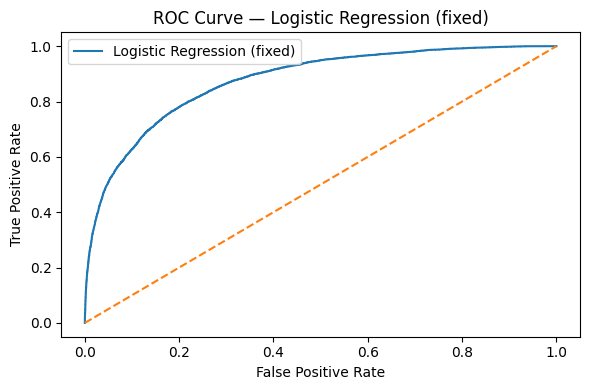

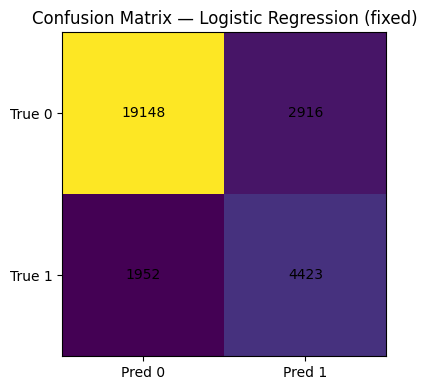

In [8]:
logreg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        C=1.0,
        solver="lbfgs"
    ))
])
logreg.fit(X_train, y_train)
proba_lr, thr_lr = evaluate_model("Logistic Regression (fixed)", logreg, X_test, y_test)


## 7) Random Forest (fixed sensible params)


=== Random Forest (fixed) ===
ROC-AUC : 0.8829568812296493
Accuracy: 0.8438412039804494
Precision: 0.6451080432172869
Recall   : 0.6743529411764706
F1       : 0.6594063961960273
              precision    recall  f1-score   support

           0      0.905     0.893     0.899     22064
           1      0.645     0.674     0.659      6375

    accuracy                          0.844     28439
   macro avg      0.775     0.784     0.779     28439
weighted avg      0.846     0.844     0.845     28439



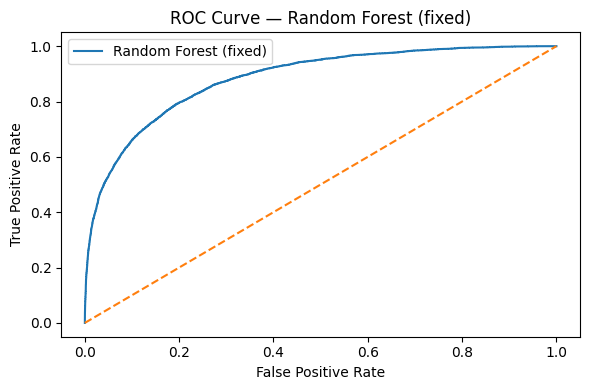

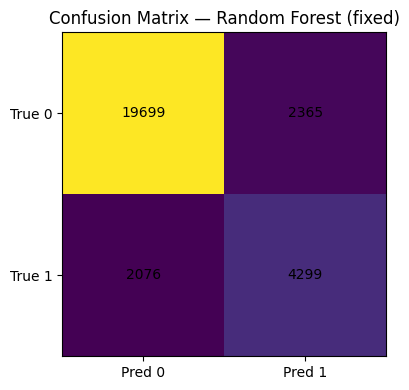

In [11]:
rf = Pipeline([
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=16,
        max_features="sqrt",
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    ))
])
rf.fit(X_train, y_train)
proba_rf, thr_rf = evaluate_model("Random Forest (fixed)", rf, X_test, y_test)


## 8) XGBoost (optional, runs only if installed)


=== XGBoost (fixed) ===
ROC-AUC : 0.8976257056121941
Accuracy: 0.8473223390414572
Precision: 0.6432295336057489
Recall   : 0.716078431372549
F1       : 0.6777019002375297
              precision    recall  f1-score   support

           0      0.915     0.885     0.900     22064
           1      0.643     0.716     0.678      6375

    accuracy                          0.847     28439
   macro avg      0.779     0.801     0.789     28439
weighted avg      0.854     0.847     0.850     28439



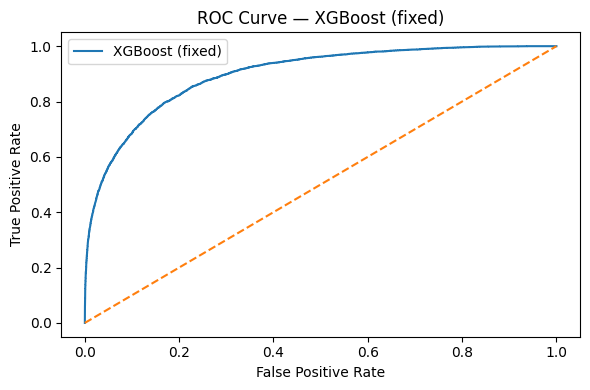

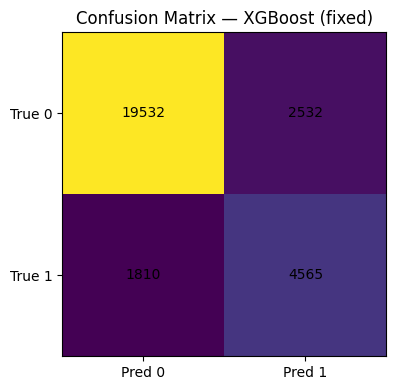

In [12]:
proba_xgb, thr_xgb = None, None
best_xgb = None

if HAS_XGB:
    xgb = Pipeline([
        ("prep", preprocess),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            n_estimators=400,
            max_depth=6,
            learning_rate=0.06,
            subsample=0.9,
            colsample_bytree=0.9,
            tree_method="hist",
            n_jobs=-1,
            random_state=42
        ))
    ])
    xgb.fit(X_train, y_train)
    proba_xgb, thr_xgb = evaluate_model("XGBoost (fixed)", xgb, X_test, y_test)
    best_xgb = xgb
else:
    print("XGBoost not installed — skipping.")


## 9) Save models, thresholds & test indices

In [13]:
# Save models
joblib.dump(logreg, "model_logreg_intermediate.pkl")
joblib.dump(rf, "model_rf_intermediate.pkl")
# Backward-compatible names
joblib.dump(logreg, "model_logreg.pkl")
joblib.dump(rf, "model_rf.pkl")
if best_xgb is not None:
    joblib.dump(best_xgb, "model_xgb_intermediate.pkl")

In [14]:
# Metrics table
def row(name, y_true, proba, thr):
    if proba is None:
        return None
    pred = (proba >= thr).astype(int)
    return {
        "model": name,
        "threshold": thr,
        "roc_auc": roc_auc_score(y_true, proba),
        "accuracy": accuracy_score(y_true, pred),
        "precision": precision_score(y_true, pred),
        "recall": recall_score(y_true, pred),
        "f1": f1_score(y_true, pred)
    }

rows = [
    row("LogisticRegression_fixed", y_test, proba_lr, thr_lr),
    row("RandomForest_fixed", y_test, proba_rf, thr_rf)
]
if proba_xgb is not None:
    rows.append(row("XGBoost_fixed", y_test, proba_xgb, thr_xgb))

metrics_df = pd.DataFrame([r for r in rows if r is not None]).sort_values("roc_auc", ascending=False)
metrics_df.to_csv("metrics_models_intermediate.csv", index=False)
print("Saved metrics_models_intermediate.csv")
display(metrics_df)

Saved metrics_models_intermediate.csv


,model,threshold,roc_auc,accuracy,precision,recall,f1
2,XGBoost_fixed,0.311954,0.897626,0.847322,0.643230,0.716078,0.677702
1,RandomForest_fixed,0.324867,0.882957,0.843841,0.645108,0.674353,0.659406
0,LogisticRegression_fixed,0.600356,0.874465,0.828827,0.602671,0.693804,0.645034


In [16]:
# Thresholds for Model Evaluation
thresholds = {"LogisticRegression_fixed": thr_lr, "RandomForest_fixed": thr_rf}
if proba_xgb is not None:
    thresholds["XGBoost_fixed"] = thr_xgb

with open("thresholds_intermediate.json", "w", encoding="utf-8") as f:
    json.dump(thresholds, f, indent=2)
print("Saved thresholds_intermediate.json")

Saved thresholds_intermediate.json


In [18]:
# Keep Model Evaluation compatible
pd.Series(X_test.index, name="index").to_csv("test_indices.csv", index=False)
pd.Series(y_test, name="RainTomorrow").to_csv("y_test.csv", index=False)
print("Saved: test_indices.csv, y_test.csv")

Saved: test_indices.csv, y_test.csv
